
# FNC 7.2 — EVD Exercises 3, 6, 7, 8 (Python Notebook)

This notebook solves the **programming** problems from **FNC 7.2 — Eigenvalue decomposition**.

- **Exercise 3**: eigenvalues of several small matrices; verify `rank(λI - A)` is singular for each eigenvalue.
- **Exercise 6**: string-of-masses model — build the matrix **A** for `n=40`, compute an EVD, and plot the three eigenvectors with smallest absolute eigenvalues.
- **Exercise 7**: Francis QR iteration experiment — construct a random matrix with prescribed eigenvalues and run 200 steps.
- **Exercise 8**: random-matrix eigenvalue clouds and perturbations; triangularization effects; condition numbers and sensitivity (Theorem 7.2.9).

> Tested with Python 3.10+ on a standard scientific stack. The notebook generates all assets on the fly.


In [1]:

# If you're running locally and miss a dependency, uncomment the next line.
# %pip install numpy scipy matplotlib tqdm

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvals, matrix_rank, norm
from scipy import linalg as sla
from tqdm import trange

np.set_printoptions(precision=6, suppress=True)
print("NumPy version:", np.__version__)


NumPy version: 1.26.4



## Exercise 3 — Eigenvalues and rank checks

Define the matrices exactly as in the textbook image and verify that for each eigenvalue `λ`,
`rank(λI - A) < n` (i.e., singular).


In [2]:

A = np.array([[ 2, -1,  0],
              [-1,  2, -1],
              [ 0, -1,  2]], dtype=float)

B = np.array([[ 2, -1, -1],
              [-2,  2, -1],
              [-1, -2,  2]], dtype=float)

C = np.array([[ 2, -1, -1],
              [-1,  2, -1],
              [-1, -1,  2]], dtype=float)

D = np.array([[ 3, 1, 0, 0],
              [ 1, 3, 1, 0],
              [ 0, 1, 3, 1],
              [ 0, 0, 1, 3]], dtype=float)

E = np.array([[ 4, -3, -2, -1],
              [-2,  4, -2, -1],
              [-1, -2, -1,  4],
              [ 1, -2, -1,  4]], dtype=float)

def check_matrix(M, name):
    lam = eigvals(M)
    n = M.shape[0]
    print(f"\n{name}: eigenvalues =", np.round(lam, 6))
    for i, l in enumerate(lam):
        r = matrix_rank(l*np.eye(n) - M)
        print(f"  λ[{i}]={l:.6g} -> rank(λI - {name}) = {r}  (< {n} ? {'YES' if r < n else 'NO'})")

for (M, nm) in [(A,"A"), (B,"B"), (C,"C"), (D,"D"), (E,"E")]:
    check_matrix(M, nm)



A: eigenvalues = [3.414214 2.       0.585786]
  λ[0]=3.41421 -> rank(λI - A) = 3  (< 3 ? NO)
  λ[1]=2 -> rank(λI - A) = 2  (< 3 ? YES)
  λ[2]=0.585786 -> rank(λI - A) = 2  (< 3 ? YES)

B: eigenvalues = [-0.627365+0.j        3.313683+0.421053j  3.313683-0.421053j]
  λ[0]=-0.627365+0j -> rank(λI - B) = 2  (< 3 ? YES)
  λ[1]=3.31368+0.421053j -> rank(λI - B) = 2  (< 3 ? YES)
  λ[2]=3.31368-0.421053j -> rank(λI - B) = 2  (< 3 ? YES)

C: eigenvalues = [ 3. -0.  3.]
  λ[0]=3 -> rank(λI - C) = 1  (< 3 ? YES)
  λ[1]=-4.44089e-16 -> rank(λI - C) = 2  (< 3 ? YES)
  λ[2]=3 -> rank(λI - C) = 1  (< 3 ? YES)

D: eigenvalues = [1.381966 2.381966 4.618034 3.618034]
  λ[0]=1.38197 -> rank(λI - D) = 3  (< 4 ? YES)
  λ[1]=2.38197 -> rank(λI - D) = 4  (< 4 ? NO)
  λ[2]=4.61803 -> rank(λI - D) = 4  (< 4 ? NO)
  λ[3]=3.61803 -> rank(λI - D) = 3  (< 4 ? YES)

E: eigenvalues = [-1.89517 +0.j        6.696067+0.j        3.099552+0.567196j
  3.099552-0.567196j]
  λ[0]=-1.89517+0j -> rank(λI - E) = 3  (< 4 ? YES


## Exercise 6 — String of `n` point masses (EVD and modes)


Selected eigenvalues (smallest |λ|): [0.005868 0.023439 0.052609]


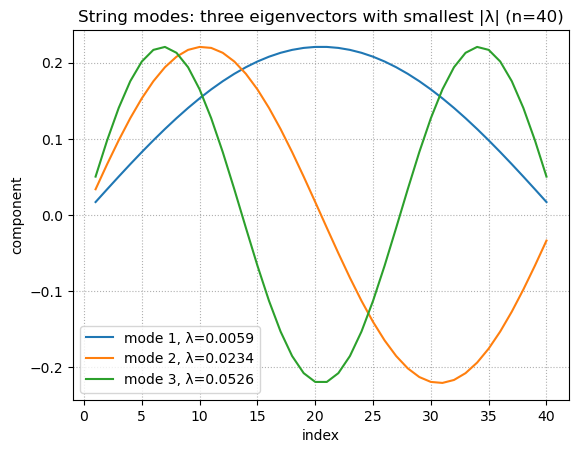

In [3]:

def tridiag(a, b, c, n):
    """Return an n-by-n tridiagonal matrix with sub=a, diag=b, super=c."""
    M = np.zeros((n, n), dtype=float)
    i = np.arange(n)
    M[i, i] = b
    M[i[1:], i[:-1]] = a
    M[i[:-1], i[1:]] = c
    return M

n = 40
K = tridiag(-1.0, 2.0, -1.0, n)

w, V = sla.eigh(K)  # symmetric; eigenvalues ascending
idx = np.argsort(np.abs(w))[:3]  # three smallest |λ|
w_sel = w[idx]
V_sel = V[:, idx]

print("Selected eigenvalues (smallest |λ|):", w_sel)

x = np.arange(1, n+1)
plt.figure()
for j in range(3):
    plt.plot(x, V_sel[:, j], label=f"mode {j+1}, λ={w_sel[j]:.4f}")
plt.title("String modes: three eigenvectors with smallest |λ| (n=40)")
plt.xlabel("index")
plt.ylabel("component")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()



## Exercise 7 — Francis QR iteration ordering experiment


First 10 diagonal entries after 200 steps: [10.4       9.4       8.4       7.4       5.919737 -9.119737 -2.538228
 -0.661772 -7.423364  4.223364]
Diagonal appears sorted (ascending or descending)? False


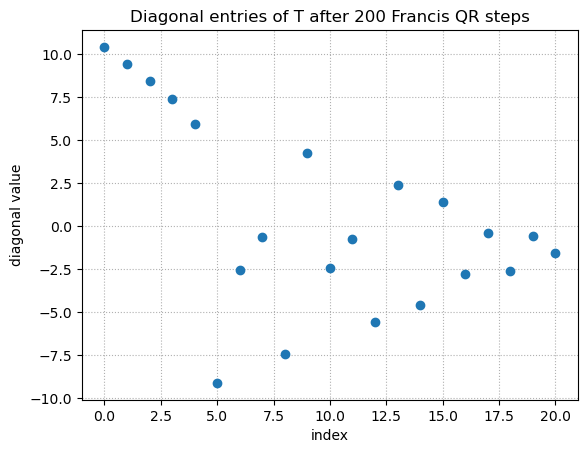

In [4]:

def make_with_spectrum(eigs, seed=0):
    rng = np.random.default_rng(seed)
    n = len(eigs)
    Q = rng.normal(size=(n, n))
    while np.linalg.matrix_rank(Q) < n:
        Q = rng.normal(size=(n, n))
    Qi, _ = np.linalg.qr(Q)  # orthonormal
    A = Qi @ np.diag(eigs) @ Qi.T  # symmetric similar -> exactly those eigenvalues
    return A

def wilkinson_shift(T):
    """Wilkinson shift for trailing 2-by-2 block of (quasi-)upper-Hessenberg/triangular T."""
    a, b, c, d = T[-2, -2], T[-2, -1], T[-1, -2], T[-1, -1]
    tr = a + d
    det = a*d - b*c
    disc = tr*tr - 4*det
    mu1 = 0.5*(tr + np.sign(tr)*np.sqrt(max(disc, 0.0)))
    mu2 = det / mu1 if mu1 != 0 else 0.0
    return mu1 if abs(mu1 - d) < abs(mu2 - d) else mu2

def francis_qr(A, iters=200):
    """Simple shifted QR iteration (no deflation)."""
    T = A.copy()
    n = T.shape[0]
    for _ in range(iters):
        mu = wilkinson_shift(T)
        Q, R = np.linalg.qr(T - mu*np.eye(n))
        T = R @ Q + mu*np.eye(n)
    return T

eigs = np.arange(-9.6, 10.5, 1.0)  # -9.6, -8.6, ..., 10.4
A7 = make_with_spectrum(eigs, seed=42)

T200 = francis_qr(A7, iters=200)
diag_T = np.diag(T200)

print("First 10 diagonal entries after 200 steps:", np.round(diag_T[:10], 6))
is_sorted = np.all(np.diff(diag_T) >= 0) or np.all(np.diff(diag_T[::-1]) >= 0)
print("Diagonal appears sorted (ascending or descending)?", is_sorted)

plt.figure()
plt.plot(diag_T, marker="o", linestyle="None")
plt.title("Diagonal entries of T after 200 Francis QR steps")
plt.xlabel("index")
plt.ylabel("diagonal value")
plt.grid(True, linestyle=":")
plt.show()



## Exercise 8 — Random matrices, perturbations, and condition numbers


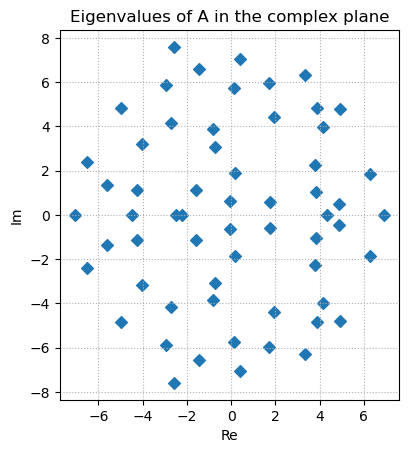

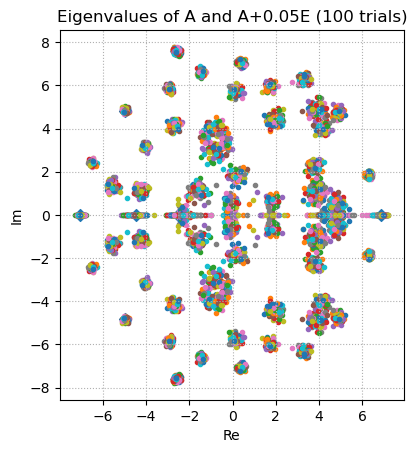

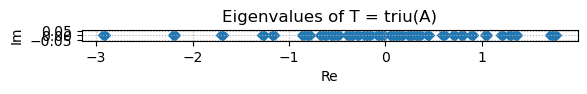

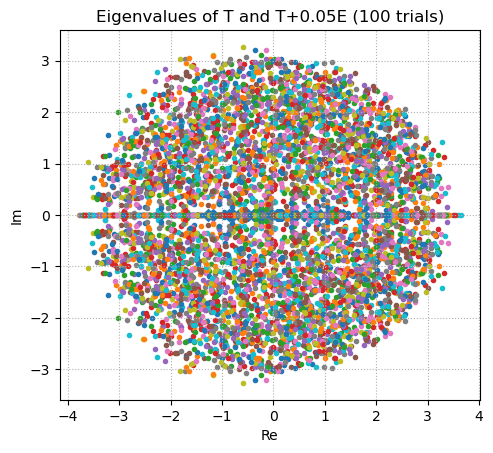

Median κ(λ) for A: 4.033916829586814
Median κ(λ) for T: 1.965117115236728e+21


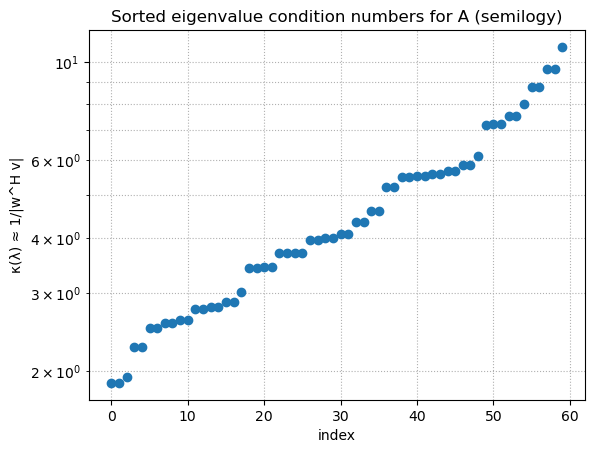

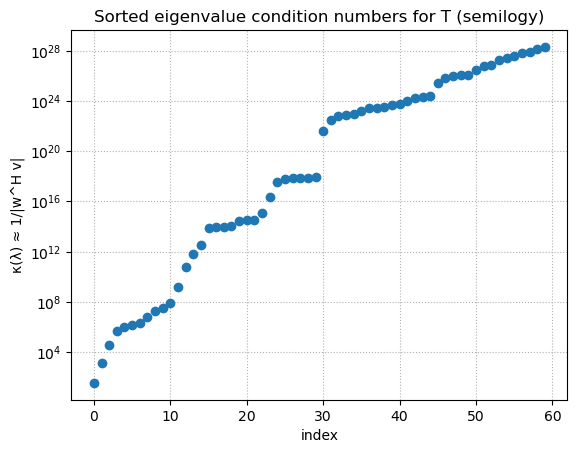


Interpretation:
- For dense nonnormal A, many eigenvalues have large κ(λ), so small perturbations can move them far.
- For upper-triangular T, eigenvalues equal the diagonal entries; but T is strongly nonnormal,
  so κ(λ) can be even larger, explaining the dramatic spreads in the T+0.05E plots.


In [5]:

rng = np.random.default_rng(0)
A8 = rng.standard_normal((60, 60))

# (a) eigenvalues of A
lamA = np.linalg.eigvals(A8)

plt.figure()
plt.scatter(lamA.real, lamA.imag, marker="D")
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Eigenvalues of A in the complex plane")
plt.xlabel("Re")
plt.ylabel("Im")
plt.grid(True, linestyle=":")
plt.show()

# (b) perturbations: A + 0.05E (E standard normal)
plt.figure()
plt.scatter(lamA.real, lamA.imag, marker="D")
for _ in range(100):
    E = rng.standard_normal((60, 60))
    lam = np.linalg.eigvals(A8 + 0.05*E)
    plt.scatter(lam.real, lam.imag, marker=".")
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Eigenvalues of A and A+0.05E (100 trials)")
plt.xlabel("Re")
plt.ylabel("Im")
plt.grid(True, linestyle=":")
plt.show()

# (c) T = triu(A): eigenvalues are its diagonal entries
T8 = np.triu(A8)
lamT = np.linalg.eigvals(T8)
plt.figure()
plt.scatter(lamT.real, lamT.imag, marker="D")
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Eigenvalues of T = triu(A)")
plt.xlabel("Re")
plt.ylabel("Im")
plt.grid(True, linestyle=":")
plt.show()

# (d) Repeat (b) with T
plt.figure()
plt.scatter(lamT.real, lamT.imag, marker="D")
for _ in range(100):
    E = rng.standard_normal((60, 60))
    lam = np.linalg.eigvals(T8 + 0.05*E)
    plt.scatter(lam.real, lam.imag, marker=".")
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Eigenvalues of T and T+0.05E (100 trials)")
plt.xlabel("Re")
plt.ylabel("Im")
plt.grid(True, linestyle=":")
plt.show()

# (e) Condition numbers via left/right eigenvectors
from scipy import linalg as sla
def eigen_cond_nums(M):
    lam, VL, VR = sla.eig(M, left=True, right=True)
    conds = []
    for j in range(len(lam)):
        v = VR[:, j]; v = v / norm(v)
        w = VL[:, j]; w = w / norm(w)
        s = abs(np.vdot(w, v))
        kappa = 1.0 / s if s > 0 else np.inf
        conds.append(kappa)
    return lam, np.array(conds)

lamA_vals, kA = eigen_cond_nums(A8)
lamT_vals, kT = eigen_cond_nums(T8)

print("Median κ(λ) for A:", np.median(kA))
print("Median κ(λ) for T:", np.median(kT))

plt.figure()
plt.semilogy(np.sort(kA), marker="o", linestyle="None")
plt.title("Sorted eigenvalue condition numbers for A (semilogy)")
plt.xlabel("index")
plt.ylabel("κ(λ) ≈ 1/|w^H v|")
plt.grid(True, which="both", linestyle=":")
plt.show()

plt.figure()
plt.semilogy(np.sort(kT), marker="o", linestyle="None")
plt.title("Sorted eigenvalue condition numbers for T (semilogy)")
plt.xlabel("index")
plt.ylabel("κ(λ) ≈ 1/|w^H v|")
plt.grid(True, which="both", linestyle=":")
plt.show()

print("\nInterpretation:")
print("- For dense nonnormal A, many eigenvalues have large κ(λ), so small perturbations can move them far.")
print("- For upper-triangular T, eigenvalues equal the diagonal entries; but T is strongly nonnormal,")
print("  so κ(λ) can be even larger, explaining the dramatic spreads in the T+0.05E plots.")
